In [1]:
import utilities
import Environment
import Shop

In [2]:
# import matplotlib.pyplot as plt
#from mab.environment import *
from mab.ts_learner import *
from mab.ucb_learner import *


#we know: number of customers per class, price of second item, conversion rate of second item
#environment setting
shop = Shop.Shop(step3=True)
env = Environment.Environment(shop.prices1,shop.prices2,shop.discounts)

shop.set_conv_rate(env.true_conv1, env.true_conv2)
#Customers



True


In [3]:
shop.best_promo_per_class()
shop.best_price

(560.0, 15)

In [4]:
n_experiments = 365
total_revenue = []
total_clairvoyant = []

arms = env.prices1
ts_learner =TS_Learner(arms=arms)      
u_learner = UCB(n_arms=len(arms))

ts_rewards_per_class_per_day = [[] for i in range(shop.n_classes)]
u_rewards_per_experiment = [np.empty([n_experiments, env.customers[i]]) for i in range(shop.n_classes)]


for day in range(n_experiments):
    env.generate_next_day_customers()
    shop.set_expected_customers(env.customers)
    ts_rewards_per_experiment = [np.array([0]) for i in range(shop.n_classes)]
    clairvoyant = []

    for idx,c in enumerate(shop.customers): # [10,20,30,40] --> [(0,10), (1,20), ...]
        for cust in range(c):
            partial_revenue = 0
            
            has_bought1 = env.round1(idx, shop.best_price[0])        
            pulled_arms = ts_learner.pull_arm_per_class()
            ts_learner.update(pulled_arms, has_bought1, idx)
            
            partial_revenue = has_bought1*shop.best_price[0]

            if has_bought1 == 1:
                has_bought2 = env.round2(idx, shop.matched_promos[idx], shop.best_price[1])
                partial_revenue += has_bought2*shop.best_price[1]

            ts_rewards_per_experiment = [np.append(ts_rewards_per_experiment[index] - r*arms[pulled_arms[index]]) for index, r in enumerate(has_bought1)]
            expected_revenue = shop.best_price[0]*env.true_conv1[idx, utilities.index(env.prices1, shop.best_price[0])] + env.true_conv1[idx, utilities.index(env.prices1, shop.best_price[0])]*env.true_conv2[idx, shop.matched_promos[idx], utilities.index(env.prices1, shop.best_price[0])]*shop.best_price[1]
            clairvoyant.append(expected_revenue)          
        total_revenue.append([np.mean(ts_rewards_per_experiment)])
        total_clairvoyant.append([np.mean(clairvoyant)])
        

        #pulled_arm = u_learner.pull_arm()
        #reward = env.round_1(pulled_arm)
        #u_learner.update(pulled_arm,reward,c)
        
        #u_learner_per_experiment[c][customer] = u_learner.rewards_per_arm[c]

TypeError: 'int' object is not subscriptable

4


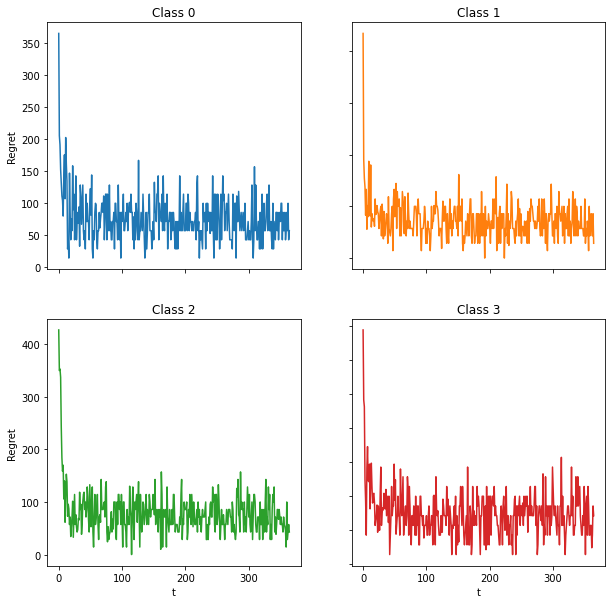

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10,10))
axs[0, 0].plot(np.array([np.mean(x) for x in ts_rewards_per_class_per_day[0]]))
axs[0, 0].set_title('Class 0')
axs[0, 1].plot(np.array([np.mean(x) for x in ts_rewards_per_class_per_day[1]]), 'tab:orange')
axs[0, 1].set_title('Class 1')
axs[1, 0].plot(np.array([np.mean(x) for x in ts_rewards_per_class_per_day[2]]), 'tab:green')
axs[1, 0].set_title('Class 2')
axs[1, 1].plot(np.array([np.mean(x) for x in ts_rewards_per_class_per_day[3]]), 'tab:red')
axs[1, 1].set_title('Class 3')

for ax in axs.flat:
    ax.set(xlabel='t', ylabel='Regret')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
